# Modelo con Random Forest

Carga de librerías

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

Carga de archivos train y test y visualización del dataframe train
- Cambiar la ruta de lectura del archivo

In [2]:
df_train = pd.read_csv(r'C:\Users\Lenovo LOQ\Desktop\maswel\train.csv')
df_test = pd.read_csv(r'C:\Users\Lenovo LOQ\Desktop\maswel\test.csv')
df_train

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,...,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,25096,20195,BIOLOGIA,LA GUAJIRA,Entre 500 mil y menos de 1 millón,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,...,N,Si,Si,Si,Secundaria (Bachillerato) incompleta,medio-alto,0.237,0.271,0.271,0.311
692496,754213,20212,PSICOLOGIA,NORTE SANTANDER,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Primaria incompleta,Si,...,N,No,Si,Si,Secundaria (Bachillerato) incompleta,bajo,0.314,0.240,0.278,0.260
692497,504185,20183,ADMINISTRACIÓN EN SALUD OCUPACIONAL,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Menos de 10 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,Si,Si,Si,Secundaria (Bachillerato) incompleta,medio-bajo,0.286,0.240,0.314,0.287
692498,986620,20195,PSICOLOGIA,TOLIMA,Entre 2.5 millones y menos de 4 millones,Menos de 10 horas,Estrato 1,No,Primaria completa,No,...,N,Si,Si,No,Primaria completa,bajo,0.132,0.426,0.261,0.328


## Preprocesamiento

En las siguientes celdas se observan características de las columnas del dataframe
 - Solo las columnas de ID, Periodo y los coeficientes son numéricas y además, no tienen ningún NaN
 - La columna objetivo tiene 4 clases equilibradas
 - Existen valores NaN en casi todas las columnas categóricas
 - La columna FAMI_TIENEINTERNET y FAMI_TIENEINTERNET.1 están repetidas
 - Las columnas ID y periodo no aportan un valor real al rendimiento final


In [3]:
df_train['RENDIMIENTO_GLOBAL'].value_counts()

alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: RENDIMIENTO_GLOBAL, dtype: int64

In [4]:
df_train.isna().sum()

ID                                    0
PERIODO                               0
ESTU_PRGM_ACADEMICO                   0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_VALORMATRICULAUNIVERSIDAD     6287
ESTU_HORASSEMANATRABAJA           30857
FAMI_ESTRATOVIVIENDA              32137
FAMI_TIENEINTERNET                26629
FAMI_EDUCACIONPADRE               23178
FAMI_TIENELAVADORA                39773
FAMI_TIENEAUTOMOVIL               43623
ESTU_PRIVADO_LIBERTAD                 0
ESTU_PAGOMATRICULAPROPIO           6498
FAMI_TIENECOMPUTADOR              38103
FAMI_TIENEINTERNET.1              26629
FAMI_EDUCACIONMADRE               23664
RENDIMIENTO_GLOBAL                    0
coef_1                                0
coef_2                                0
coef_3                                0
coef_4                                0
dtype: int64

Las columnas categóricas con más de dos clasificaciones siguen casi siempre un orden lógico al que tiene sentido asignarle una clasifcación con números, donde se entiende que bajo < medio < alto y casos similares. Debido a esto se aplica una codificación con OrdinalEncoder que permite asignar un orden a estas clasificaciones como se ve en el diccionario de abajo.

In [ ]:
ordenes = {
    'ESTU_PRGM_ACADEMICO':df_train['ESTU_PRGM_ACADEMICO'].unique().tolist(),
    'ESTU_PRGM_DEPARTAMENTO':df_train['ESTU_PRGM_DEPARTAMENTO'].unique().tolist(),
    'ESTU_VALORMATRICULAUNIVERSIDAD':['No pagó matrícula','Menos de 500 mil','Entre 500 mil y menos de 1 millón','Entre 1 millón y menos de 2.5 millones','Entre 2.5 millones y menos de 4 millones','Entre 4 millones y menos de 5.5 millones','Entre 5.5 millones y menos de 7 millones','Más de 7 millones'],
    'ESTU_HORASSEMANATRABAJA':['0','Menos de 10 horas','Entre 11 y 20 horas','Entre 21 y 30 horas','Más de 30 horas'],
    'FAMI_ESTRATOVIVIENDA':['Sin Estrato','Estrato 1','Estrato 2','Estrato 3','Estrato 4','Estrato 5','Estrato 6'],
    'FAMI_TIENEINTERNET':['No','Si'],
    'FAMI_EDUCACIONPADRE':['No Aplica','Ninguno','No sabe','Primaria incompleta','Primaria completa','Secundaria (Bachillerato) incompleta','Secundaria (Bachillerato) completa','Técnica o tecnológica incompleta','Técnica o tecnológica completa','Educación profesional incompleta','Educación profesional completa','Postgrado'],
    'FAMI_TIENELAVADORA':['No','Si'],
    'FAMI_TIENEAUTOMOVIL':['No','Si'],
    'ESTU_PRIVADO_LIBERTAD':['S','N'],
    'ESTU_PAGOMATRICULAPROPIO':['Si','No'],
    'FAMI_TIENECOMPUTADOR':['No','Si'],
    'FAMI_EDUCACIONMADRE':['No Aplica','Ninguno','No sabe','Primaria incompleta','Primaria completa','Secundaria (Bachillerato) incompleta','Secundaria (Bachillerato) completa','Técnica o tecnológica incompleta','Técnica o tecnológica completa','Educación profesional incompleta','Educación profesional completa','Postgrado'],
    'RENDIMIENTO_GLOBAL':['bajo','medio-bajo','medio-alto','alto'],
}


df = df_train.copy()
df.drop(columns=['ID', 'PERIODO', 'FAMI_TIENEINTERNET.1'], inplace=True)
cat_cols = df.select_dtypes(include=['object']).columns

encoders = {}
for col in cat_cols:
    oe = OrdinalEncoder(categories=[ordenes[col]])
    not_null_mask = df_train[col].notna()
    df.loc[not_null_mask, col] = oe.fit_transform(df_train.loc[not_null_mask, [col]])
    encoders[col] = oe

La codificación anterior se aplica solamente a los valores no nulos de las columnas, en las que luego se utiliza un IterativeImputer para llenar de manera más objetiva los valores faltantes, relacionando de manera automática los valores faltantes con las demás columnas con respecto a otros registros similares

In [ ]:
imputer_cat = IterativeImputer(
    estimator=None,           
    max_iter=10,              
    tol=1e-3,                 
    n_nearest_features=None,  
    initial_strategy='most_frequent',  
    random_state=42          
)

df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

Se visualiza la correlación entre las columnas

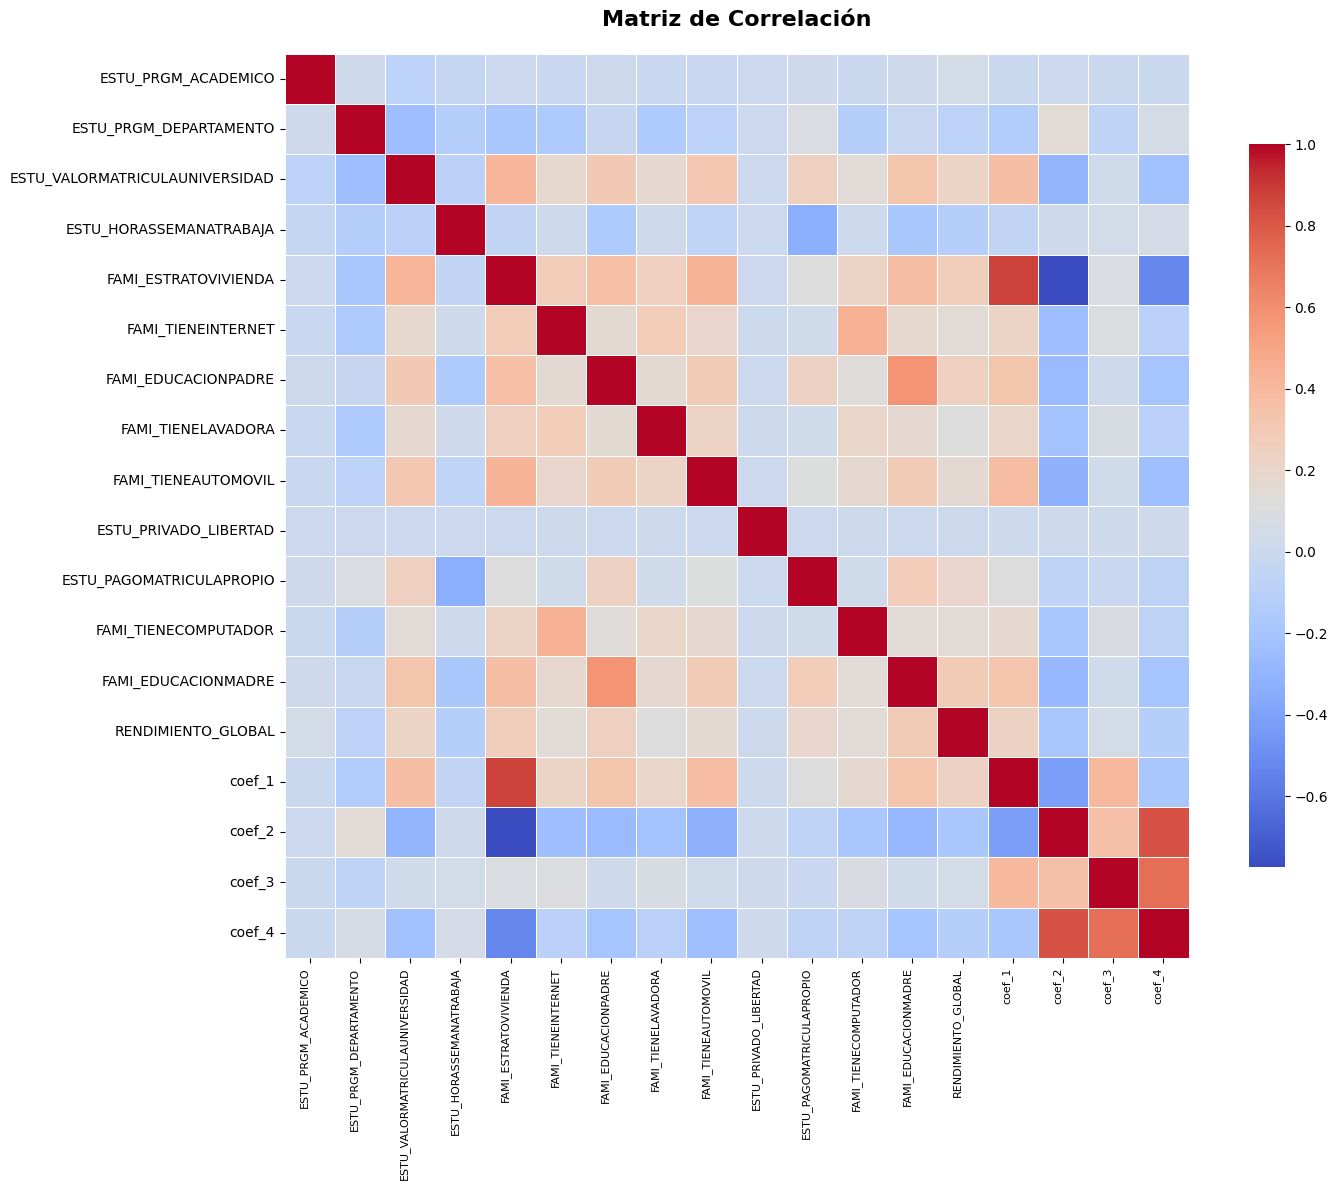

In [7]:
plt.figure(figsize=(15, 12))

sns.heatmap(df.corr(),
            annot=False,          
            cmap='coolwarm',      
            fmt='.2f',         
            square=True,         
            linewidths=0.5,    
            cbar_kws={'shrink': 0.8},  
            annot_kws={'size': 8})   

plt.title('Matriz de Correlación', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=90, ha='right',fontsize=8)
plt.yticks(rotation=0)               
plt.tight_layout()                  
plt.show()

## Modelo

Se propone un modelo RandomForest utilizando diferentes combinaciones de parámetros para buscar la más óptima, se aplica validación cruzada para mayor garantía del modelo

In [ ]:
X = df[df.columns.difference(['RENDIMIENTO_GLOBAL'])]
y = df['RENDIMIENTO_GLOBAL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

configs = [
    # {'name': 'Sencillo', 'params': {'n_estimators': 100, 'random_state': 42}},
    # {'name': 'Más árboles', 'params': {'n_estimators': 300, 'random_state': 42}},
    # {'name': 'Profundidad limitada', 'params': {'n_estimators': 200, 'max_depth': 15, 'random_state': 42}},
    # {'name': 'Mínimo de muestras', 'params': {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'random_state': 42}},
    {'name': 'Optimizado', 'params': {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42}}
]

best_accuracy = 0
best_config = None

print("Probando diferentes configuraciones:\n")
print(f"{'Configuración':<20} {'Accuracy':<10} {'CV Score':<12}")
print("-" * 45)

for config in configs:
    model = RandomForestClassifier(**config['params'])
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()
    
    print(f"{config['name']:<20} {accuracy:<10.3f} {cv_mean:<12.3f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f"\n🏆 Mejor configuración: {best_config['name']}")
print(f"📊 Accuracy: {best_accuracy:.3f}")
print(f"⚙️  Parámetros: {best_config['params']}")

Probando diferentes configuraciones:

Configuración        Accuracy   CV Score    
---------------------------------------------
Optimizado           0.431      0.427       

🏆 Mejor configuración: Optimizado
📊 Accuracy: 0.431
⚙️  Parámetros: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'random_state': 42}


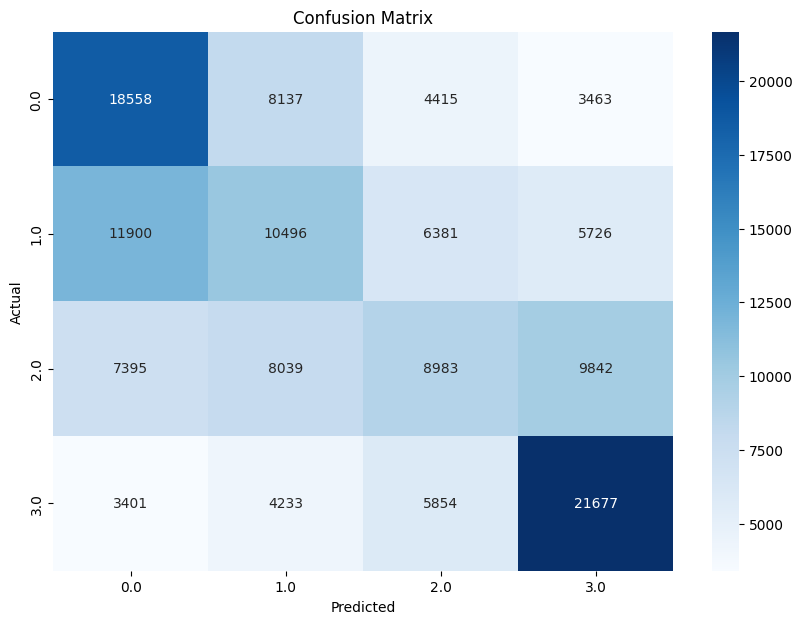

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7)) 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

El modelo finalmente tiene un aacuracy de 43%. Teniendo en cuenta que la variable objetivo tiene 4 clases balanceadas, el azar es alrededor del 25%, lo cual indica que el modelo es mejor que el azar. En la matriz de confusión se observa que el modelo tiene resultados aceptables para las clases 0 y 3 (bajo y alto) y presenta una confusión muy alta en las clases intermedias

## Solución al test

In [ ]:
df2 = df_test.copy()
df2.drop(columns=['ID', 'PERIODO', 'FAMI_TIENEINTERNET.1'], inplace=True)

ordenes = {
    'ESTU_PRGM_ACADEMICO':df_test['ESTU_PRGM_ACADEMICO'].unique().tolist(),
    'ESTU_PRGM_DEPARTAMENTO':df_test['ESTU_PRGM_DEPARTAMENTO'].unique().tolist(),
    'ESTU_VALORMATRICULAUNIVERSIDAD':['No pagó matrícula','Menos de 500 mil','Entre 500 mil y menos de 1 millón','Entre 1 millón y menos de 2.5 millones','Entre 2.5 millones y menos de 4 millones','Entre 4 millones y menos de 5.5 millones','Entre 5.5 millones y menos de 7 millones','Más de 7 millones'],
    'ESTU_HORASSEMANATRABAJA':['0','Menos de 10 horas','Entre 11 y 20 horas','Entre 21 y 30 horas','Más de 30 horas'],
    'FAMI_ESTRATOVIVIENDA':['Sin Estrato','Estrato 1','Estrato 2','Estrato 3','Estrato 4','Estrato 5','Estrato 6'],
    'FAMI_TIENEINTERNET':['No','Si'],
    'FAMI_EDUCACIONPADRE':['No Aplica','Ninguno','No sabe','Primaria incompleta','Primaria completa','Secundaria (Bachillerato) incompleta','Secundaria (Bachillerato) completa','Técnica o tecnológica incompleta','Técnica o tecnológica completa','Educación profesional incompleta','Educación profesional completa','Postgrado'],
    'FAMI_TIENELAVADORA':['No','Si'],
    'FAMI_TIENEAUTOMOVIL':['No','Si'],
    'ESTU_PRIVADO_LIBERTAD':['S','N'],
    'ESTU_PAGOMATRICULAPROPIO':['Si','No'],
    'FAMI_TIENECOMPUTADOR':['No','Si'],
    'FAMI_EDUCACIONMADRE':['No Aplica','Ninguno','No sabe','Primaria incompleta','Primaria completa','Secundaria (Bachillerato) incompleta','Secundaria (Bachillerato) completa','Técnica o tecnológica incompleta','Técnica o tecnológica completa','Educación profesional incompleta','Educación profesional completa','Postgrado'],
    'RENDIMIENTO_GLOBAL':['bajo','medio-bajo','medio-alto','alto'],
}

cat_cols = df2.select_dtypes(include=['object']).columns

encoders = {}
for col in cat_cols:
    oe = OrdinalEncoder(categories=[ordenes[col]])
    not_null_mask = df_test[col].notna()
    df2.loc[not_null_mask, col] = oe.fit_transform(df_test.loc[not_null_mask, [col]])
    encoders[col] = oe

In [ ]:
imputer_cat = IterativeImputer(
    estimator=None,           
    max_iter=10,              
    tol=1e-3,                 
    n_nearest_features=None,  
    initial_strategy='most_frequent',  
    random_state=42          
)

df2[cat_cols] = imputer_cat.fit_transform(df2[cat_cols])

Dataframe para aplicar el modelo

In [ ]:
X2 = df2[X.columns]
y_pred_test = model.predict(X2)
submission = pd.DataFrame({
    'ID': df_test['ID'],
    'RENDIMIENTO_GLOBAL': y_pred_test
})

Mapeo de Rendimiento para revertir codificación

In [ ]:
submission['RENDIMIENTO_GLOBAL'] = submission['RENDIMIENTO_GLOBAL'].map({0: 'bajo', 1: 'medio-bajo', 2: 'medio-alto', 3: 'alto'})


,ID,RENDIMIENTO_GLOBAL
0,550236,alto
1,98545,medio-bajo
2,499179,medio-alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,bajo
296782,209415,alto
296783,239074,medio-alto
296784,963852,alto


Archivo para subir a Kaggle

In [29]:
submission.to_csv('test.csv', index=False)